In [2]:
import anndata as ad
import json
import numpy as np
import os
import pandas as pd
import re
import requests
import scanpy as sc
import subprocess
from PIL import Image
from random import randint
from scipy import sparse
from urllib.parse import quote

Specify the folder that includes these files...
- raw_feature_bc_matrix.h5
- spatial/
  - detected_tissue_image.jpg
  - scalefactors_json.json
  - tissue_hires_image.png
  - tissue_lowres_image.png*
  - tissue_positions_list.csv

*the lowres image will be deleted but is required for `read_visium()`

In [31]:
folder = '/Users/jason/Downloads/cxg353_Arutyunyan/WS_PLA_S9101767'

#REQUIRED to include empty spots, so specify raw_feature_bc_matrix.h5
adata = sc.read_visium(folder, count_file='raw_feature_bc_matrix.h5')

/opt/anaconda3/envs/lattice/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [32]:
adata.var.set_index('gene_ids', inplace=True)

In [33]:
if adata.obs.shape[0] < 4992:
    all_barcodes = pd.read_csv(folder + '/spatial/tissue_positions_list.csv', header=None)
    missing_barcodes = all_barcodes[all_barcodes[0].isin(list(adata.obs.index)) == False]
    missing_barcodes.set_index(0, inplace=True)
    missing_barcodes.rename(columns={1: 'in_tissue', 2:'array_row', 3:'array_col'}, inplace=True)
    empty_matrix = sparse.csr_matrix((missing_barcodes.shape[0], adata.var.shape[0]))
    missing_adata = ad.AnnData(empty_matrix, var=adata.var, obs=missing_barcodes[['in_tissue','array_row','array_col']])
    comb_adata = ad.concat([adata, missing_adata], uns_merge='first', merge='first')
    comb_adata.obsm['spatial'] = np.concatenate((adata.obsm['spatial'],missing_barcodes[[5,4]].values))
    adata = comb_adata

In [34]:
library_id = list(adata.uns['spatial'].keys())[0]

In [35]:
#False if multiple slides are integrated
adata.uns['spatial']['is_single'] = True

In [36]:
#OPTIONAL
adata.uns['spatial_metadata'] = adata.uns['spatial'][library_id]['metadata']

#MUST NOT SUBMIT metadata or lowres or fiducial_diameter_fullres
del adata.uns['spatial'][library_id]['metadata']
del adata.uns['spatial'][library_id]['images']['lowres']
del adata.uns['spatial'][library_id]['scalefactors']['tissue_lowres_scalef']
del adata.uns['spatial'][library_id]['scalefactors']['fiducial_diameter_fullres']

In [37]:
#PREFERRED to include fullres image
fullres_path = '/Users/jason/Downloads/cxg353_Arutyunyan/WS_PLA_S9101767.tif'
adata.uns['spatial'][library_id]['images']['fullres'] = np.asarray(Image.open(fullres_path))

In [38]:
adata.uns['title'] = library_id

In [39]:
#consistent for all Visium Datasets
adata.obs['suspension_type'] = 'na'
adata.obs['assay_ontology_term_id'] = 'EFO:0010961'

In [40]:
#consistent metadata for all obs
adata.obs['is_primary_data'] = True
adata.obs['donor_id'] = 'donor_A'
adata.obs['organism_ontology_term_id'] = 'NCBITaxon:9606'
adata.obs['sex_ontology_term_id'] = 'PATO:0000383'
adata.obs['development_stage_ontology_term_id'] = 'HsapDv:0000137'
adata.obs['self_reported_ethnicity_ontology_term_id'] = 'HANCESTRO:0022'
adata.obs['tissue_type'] = 'tissue'

In [41]:
#probably consistent metadata for all obs
adata.obs['tissue_ontology_term_id'] = 'UBERON:0001115'
adata.obs['disease_ontology_term_id'] = 'PATO:0000461'

In [42]:
#map in cell_types
adata.obs['cell_type_ontology_term_id'] = 'CL:0000003'

In [43]:
ref_dir = 'ref_files/'
ref_files = [
    'genes_ercc.csv',
    'genes_homo_sapiens.csv',
    'genes_mus_musculus.csv',
    'genes_sars_cov_2.csv'
]

if not os.path.exists(ref_dir + 'genes_approved.csv'):
    ids = pd.DataFrame()
    for f in ref_files:
        df = pd.read_csv(ref_dir + f, names=['feature_id','symb','num','length'],dtype='str',index_col=False)
        ids = ids.append(df)
        os.remove(f)
    ids.to_csv(ref_dir + 'genes_approved.csv', index=False)

approved = pd.read_csv(ref_dir + 'genes_approved.csv',dtype='str')

In [44]:
adata.var.reset_index(inplace=True)
var_to_keep = adata.var[adata.var['gene_ids'].isin(approved['feature_id'])].index
adata = adata[:, var_to_keep]
adata.var.set_index('gene_ids', inplace=True)
adata.var.drop(columns=['feature_types'], inplace=True)

adata.var['feature_is_filtered'] = False

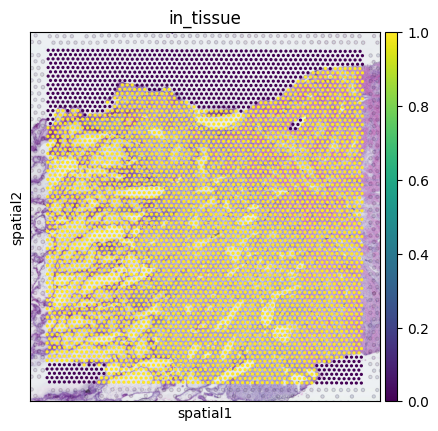

In [45]:
sc.pl.spatial(adata,
              library_id=library_id,
              color='in_tissue')

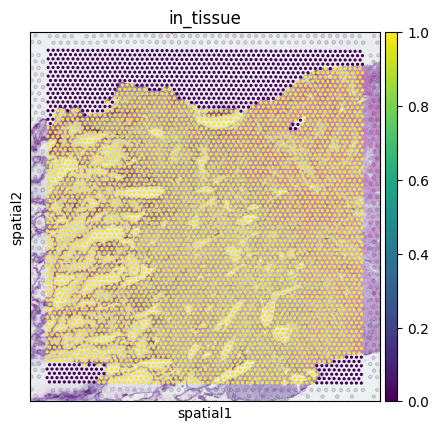

In [46]:
sc.pl.spatial(adata,
              library_id=library_id,
              color='in_tissue',
              img_key='fullres',
              scale_factor=1
             )

In [48]:
new_one = library_id + '_revised.h5ad'
adata.write(filename=new_one, compression='gzip')

In [49]:
validate_process = subprocess.run(['cellxgene-schema', 'validate', new_one], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
for line in validate_process.stdout.decode('utf-8').split('\n'):
    print(line)
for line in validate_process.stderr.decode('utf-8').split('\n'):
    print(line)

Loading dependencies
Loading validator modules

Starting validation...
Validation complete in 0:00:03.241426 with status is_valid=True

